# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #5
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 2nd, 2018 at 11:00am

**Instructions:**

- Upload your final answers in a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Simulated Annealing 
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our loss function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? 
Connect the trends you observe in the visualization to the lecture on Markov Chains.

In [1]:
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline
import time
df = pd.read_csv('HW3_data.csv',header=None)

In [2]:
# total cost
def cost(x,y,l1,l2):
    return np.sum(0.000045*l2**2*y - 0.000098*l1**2*x + 0.003926*l1*x*np.exp(-0.1*(l1**2+l2**2)))

In [3]:
import math
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

In [4]:
def proposalfunc(vec):
    a = np.random.multivariate_normal(vec,[[1,0],[0,1]])
    return a

In [5]:
#adapted from Rahul
def sa(initials, epochs):
    accumulator=[]
    tcosts = []
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = cost(df.iloc[:,0],df.iloc[1,:],old_solution[0],old_solution[1])
    accepted=0
    total=0
    for index in range(epochs):
        print("Epoch", index)
        if index > 0:
            T = tf(T)
            length=itf(length)
        tvars = []
        #print("Temperature", T, "Length", length)
        for it in range(length):
            total+=1
            new_solution = proposalfunc(old_solution)
            new_energy = cost(df.iloc[0,:],df.iloc[1,:],new_solution[0],new_solution[1])
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                tvars.append(new_energy)
                accumulator.append((T, new_solution, new_energy))
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                tvars.append(old_energy)
                accumulator.append((T, old_solution, old_energy))
        tcosts.append(tvars)
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator,tcosts

In [6]:
inits=dict(solution=[-5,0], length=500, T=10)
bmeta, bs, be, out,tcosts = sa(inits, 10)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
frac accepted 0.5649830612873422 total iterations 12988 bmeta {'index': 7789, 'temp': 2.097152000000001}


Note: I used epochs as a stopping criteria since this was basically implemented by Rahul. Of course other conditions based on the lambda values could have been made but this does a relatively good job as we can see with the parameters below:

In [7]:
bs,be

(array([2.04971715, 0.00428278]), -9.934037504045136)

I have plotted the cost function below to get a sense of where this point is

In [8]:
lambda1 = np.linspace(-5,5,100)
lambda2 = np.linspace(-5,5,100)

Lval = np.zeros((lambda1.shape[0],lambda2.shape[0]))

for i in range(len(lambda1)):
    for j in range(len(lambda2)):
        Lval[i,j] = np.sum(0.000045*lambda2[j]**2*df.iloc[1,:] - 0.000098*lambda1[i]**2*df.iloc[0,:] + 0.003926*lambda1[i]*df.iloc[0,:]*np.exp(-0.1*(lambda1[i]**2+lambda2[j]**2)))
        

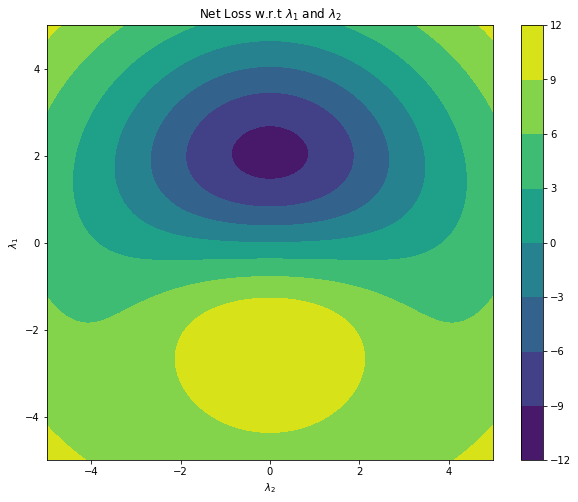

In [9]:
plt.figure(figsize=(10,8))
plt.title(r'Net Loss w.r.t $\lambda_1$ and $\lambda_2$')
plt.contourf(lambda1,lambda2,Lval)
plt.colorbar()
#plt.scatter(0,2.05384,c='r')
plt.xlabel(u'$\lambda_2$')
plt.ylabel(u'$\lambda_1$')
jval = 10
idx = 0
# cols =['r','g','b','y','navy','o','pink','peru','dimgrey','mistyrose']
# for i in range(len(out)):
#     if out[i][0] == jval:
#         plt.scatter(out[i][1][0],out[i][1][1],c=cols[idx])
#     else:
#         jval = out[i][0]
#         idx+=1
#         plt.scatter(out[i][1][0],out[i][1][1],c=cols[idx])

Each plot here actually represents sampling from a boltzmann distribution (with a specific T) which is the stationary distribution of a markov chain (at each T we have a homogenous Markov Chain). What we are seeing is that at lower temperatures we tend to be highly distributed about the mean of the boltzmann so T is basically controlling the width, and hence allowing us to pick out this minimum.

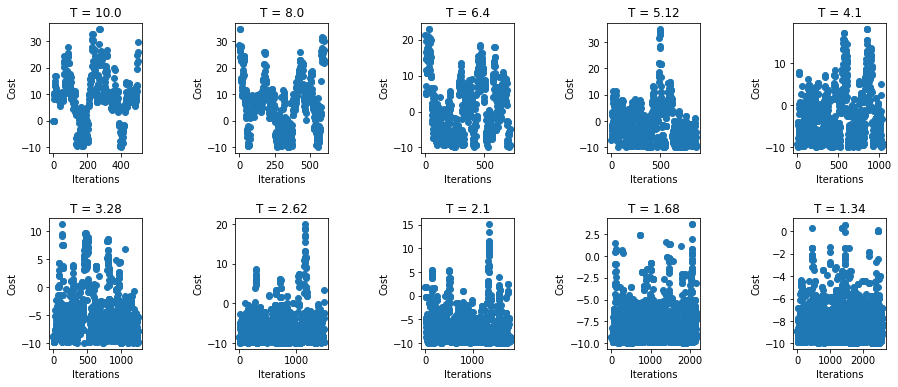

In [25]:
fig, axs = plt.subplots(2,5,figsize=(15,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=1)

axs = axs.ravel()
T = 100/8
for i in range(10):

    axs[i].scatter(range(len(tcosts[i])),tcosts[i])
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Cost')
    axs[i].set_title('T = '+str(round(.8*T,2)))
    T = .8*T


## Problem 2: A Tired Salesman

In the famous traveling salesman problem, the quality of the solution can be measured in 
different ways, beyond finding the shortest path.  For example, the total time of travel may also be important, and may depend on the means of transportation that connect pairs of 
cities.  Consider a random distribution of $N$ points on a plane representing the cities 
that must be visited by the traveling salesman.  Each point is an (x,y) coordinate where both x and y are integers in the range [1, 50). Assign a value $s_i$ where $i\in [1,\dots,N]$ to each city that represents its size measured by population.  Let $\forall s_i, \  s_i \in [1, 10)$.  If two cities are farther away from each other than a **distance threshold of 10** and both have populations greater than a **population threshold of 5** assume there is a flight connection between them.  In all other cases assume that our poor salesman would have to drive between cities. Flying is faster than driving by a factor of 10. 

1. Use Simulated Annealing to find solutions to the traveling salesman problem for 
$N=100$, optimizing the travel path for the total distance travelled (but keeping track 
of the time of travel). 

2. Now redo the problem by optimizing the the path for the total time of travel (but keeping track of the distance traveled). Are the two solutions similar or different? 

3. How do your results change if the population and distance thresholds for the exisitence of a flight between two cities are altered?


In [2]:
#adapted from Rahul's code

def alltours_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): 
    "Choose the tour with the minimum tour length."
    return min(tours, key=tour_length)


In [3]:
def alltours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + Tour(rest)
            for rest in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

Tour = list  # Tours are implemented as lists of cities

In [4]:
def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))
def tour_time(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(timer(tour[i], tour[i-1]) 
               for i in range(len(tour)))


In [5]:
# Cities are represented as Points, which are a subclass of complex numbers
from collections import namedtuple

City = namedtuple('City', ['x', 'y','pop'], verbose=True)

from builtins import property as _property, tuple as _tuple
from operator import itemgetter as _itemgetter
from collections import OrderedDict

class City(tuple):
    'City(x, y, pop)'

    __slots__ = ()

    _fields = ('x', 'y', 'pop')

    def __new__(_cls, x, y, pop):
        'Create new instance of City(x, y, pop)'
        return _tuple.__new__(_cls, (x, y, pop))

    @classmethod
    def _make(cls, iterable, new=tuple.__new__, len=len):
        'Make a new City object from a sequence or iterable'
        result = new(cls, iterable)
        if len(result) != 3:
            raise TypeError('Expected 3 arguments, got %d' % len(result))
        return result

    def _replace(_self, **kwds):
        'Return a new City object replacing specified fields with new values'
        result = _self._make(map(kwds.pop, ('x', 'y', 'pop'), _self))
        if kwds:
            raise ValueError('Got unexpected field names: %r' % list(kwds))
        return result

    def __repr__(self):
        '

In [6]:
import math
globaldist = 10
globalpop = 5
def distance(A, B): 
    "The distance between two points."
    return math.sqrt((A.x - B.x)*(A.x - B.x) + (A.y - B.y)*(A.y - B.y))

def timer(A,B):
    "time to get between a and b"
    # assume unit speed on ground
    tval=0
    dist = math.sqrt((A.x - B.x)*(A.x - B.x) + (A.y - B.y)*(A.y - B.y))
    if (dist>globaldist) and (A.pop>globalpop) and(B.pop>globalpop):
        tval = dist/10
    else:
        tval = dist
    return tval
 
def Cities(n, width, height, seed=42):
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    np.random.seed(seed*n)
    return frozenset(City(random.randrange(1,width), random.randrange(1,height),np.random.uniform(1,10))
                     for c in range(n))

def plot_tour(tour):
    "Plot the cities as circles and the tour as lines between them. Start city is red square."
    start = tour[0]
    plot_lines(list(tour) + [start])
    plot_lines([start], 'rs') # Mark the start city with a red square
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([p.x for p in points], [p.y for p in points], style)
    plt.axis('scaled'); plt.axis('off')
    
def plot_tsp(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    # Find the solution and time how long it takes
    t0 = time.clock()
    tour = algorithm(cities)
    t1 = time.clock()
    assert valid_tour(tour, cities)
    plot_tour(tour); plt.show()
    print("{} city tour with length {:.1f} in {:.3f} secs for {}"
          .format(len(tour), tour_length(tour), t1 - t0, algorithm.__name__))
    
def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)

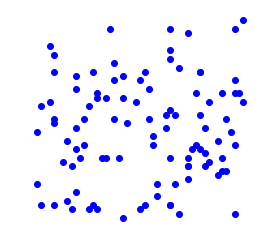

In [7]:
mycities = Cities(100,50,50)
plot_lines(mycities, 'bo')

In [8]:
def nn_tsp(cities):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to the nearest neighboring city, C,
    that has not yet been visited."""
    start = first(cities)
    tour = [start]
    unvisited = set(cities - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda c: distance(c, A))

In [9]:
# def reverse_segment(input_tour, i, j):
#     "Reverse segment tour[i:j] of a tour" 
#     input_tour[i:j] = reversed(input_tour[i:j])

def change_tour(input_tour):
    "Change a tour for tsp iteration"
    
    #possible_indices = range(1, len(input_tour)) why not?
    possible_indices = range(len(input_tour))
    # take two random indices to swap
    c1 = np.random.choice(possible_indices)
    c2 = np.random.choice(possible_indices)
    
    new_tour = change_path(input_tour, c1, c2)
    
    return new_tour
    
    
def swap_cities(input_tour, i, j):
    "Swap two cities at index i and j in a tour"
    
    # save city1
    city1 = input_tour[i]
    
    # save city2
    city2 = input_tour[j]
    
    new_tour = input_tour.copy()
    
    # swap
    new_tour[j] = city1
    new_tour[i] = city2
        
    return new_tour
    
change_path = swap_cities  
    

In [10]:
# We've constructed our own simulated annealing function for tsp but we don't
# really need to make any changes.  So we'll just comment the regular sa :-)
def sa_tsp(energyfunc,tracker, initials, epochs, tempfunc, iterfunc, proposalfunc):
    """
    Run simulated annealing on a tsp.
    """
    # Accumulate results in the same form as initals
    accumulator=[]
    
    # time tracker
    timer_vals = []
    
    # Our initial state is in initials['solution']
    best_solution = old_solution = initials['solution']
    
    # Our initial temperature is in initials['T']
    T=initials['T']
    
    # Our initial length (i.e. number of iterations per epoch)
    # is in initals['length']
    length=initials['length']
    
    # initialize the energy of our current state by running the 
    # energy function on our initial solution
    best_energy = old_energy = energyfunc(old_solution)
    
    # keep track of accepted proposals and total iterations
    accepted=0
    total=0
    
    for index in range(epochs):
        #print("Epoch", index)
        
        # if we're past the first index, we need
        # to update our cooling schedule and iteration
        # schedule
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            
#         if index % 100 == 0:
#             print("Temperature", T, "Length", length)
    
        # run through the iterations for each epoch
        for it in range(length):
            
            # keep track of total proposals
            total+=1
            
            # get a new proposal and calculate its energy
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            timing = tracker(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                
                # Accept proposed solution
                accepted+=1.0
                accumulator.append((T, new_solution, new_energy,timing))
                
                # we have a new candidate for optimum (minimum)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                    best_tracker = timing
                    
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy,timing))
    
    best_meta=dict(index=best_index, temp=best_temp)
#     print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy,best_tracker, accumulator

#### 1. Optimizing Distance

In [12]:
list(mycities)

[City(x=10, y=17, pop=8.961283685888045),
 City(x=39, y=25, pop=9.40423351609434),
 City(x=14, y=4, pop=3.050789934801643),
 City(x=13, y=27, pop=1.1113505371818442),
 City(x=16, y=15, pop=8.065350486980424),
 City(x=48, y=30, pop=6.481500134850636),
 City(x=19, y=24, pop=9.61888308899489),
 City(x=10, y=31, pop=1.2164947518665046),
 City(x=31, y=22, pop=7.312491799854426),
 City(x=10, y=22, pop=3.0665472149427475),
 City(x=47, y=18, pop=5.5218790654002925),
 City(x=5, y=24, pop=1.2949083494141955),
 City(x=22, y=23, pop=1.0111130695368447),
 City(x=5, y=23, pop=5.140410509007243),
 City(x=12, y=24, pop=1.0840450972903737),
 City(x=32, y=45, pop=8.934554304429113),
 City(x=10, y=34, pop=9.175799249646154),
 City(x=8, y=5, pop=5.685521654153759),
 City(x=45, y=12, pop=4.814803823528739),
 City(x=36, y=15, pop=8.474538592126397),
 City(x=36, y=44, pop=5.064490378876271),
 City(x=7, y=14, pop=5.9279343750823585),
 City(x=27, y=24, pop=7.104747582916124),
 City(x=36, y=13, pop=5.9824868498

In [52]:
initial_tour = list(mycities)
length_func1 = lambda temperature: np.max((np.floor(np.sqrt(temperature)).astype(int),1))
length_func2 = lambda length: max(int(math.ceil(1.2*length)), 10)
length_func = length_func1
temp_func = lambda t: 0.9*t
init_length = length_func(10000)
inits=dict(solution=initial_tour, length=init_length, T=50.0)
bmeta, bs, be,be1, out = sa_tsp(tour_length,tour_time, inits, 100000, temp_func, length_func, change_tour);


c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


Text(0,0.5,'Distance')

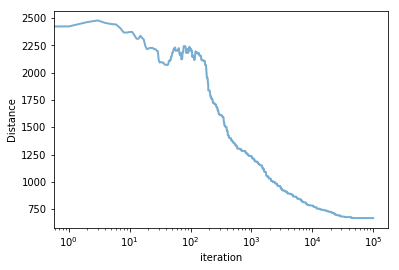

In [53]:
plt.plot(range(len(out)),[e[2] for e in out], alpha=0.6, lw=2);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('Distance')


In [54]:
print('The minimum distance = %s' %(be))

The minimum distance = 667.9122968403412


Text(0,0.5,'Time')

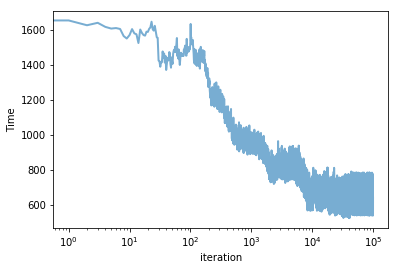

In [55]:
plt.plot(range(len(out)),[e[3] for e in out], alpha=0.6, lw=2);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('Time')


#### 2. Optimizing for Time

In [56]:
initial_tour = list(mycities)
length_func1 = lambda temperature: np.max((np.floor(np.sqrt(temperature)).astype(int),1))
length_func2 = lambda length: max(int(math.ceil(1.2*length)), 10)
length_func = length_func1
temp_func = lambda t: 0.9*t
init_length = length_func(10000)
inits=dict(solution=initial_tour, length=init_length, T=50.0)
bmeta, bs, be,be1, out = sa_tsp(tour_time,tour_length, inits, 100000, temp_func, length_func, change_tour);


c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


Text(0,0.5,'Time')

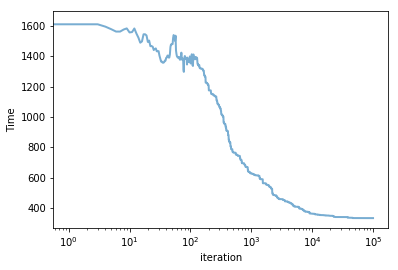

In [57]:
plt.plot(range(len(out)),[e[2] for e in out], alpha=0.6, lw=2);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('Time')


Text(0,0.5,'Distance')

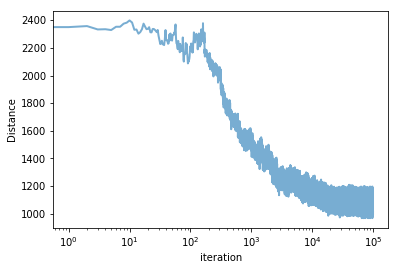

In [58]:
plt.plot(range(len(out)),[e[3] for e in out], alpha=0.6, lw=2);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('Distance')


#### 3. Testing other parameters

There are really 4 main edge cases to test:

low dist low pop

high dist low pop

low dist high pop

high dist high pop

In [59]:
dist_vals = [1,20,1,20]
pop_vals = [1,1,8,8]

In [60]:
length_func1 = lambda temperature: np.max((np.floor(np.sqrt(temperature)).astype(int),1))
length_func = length_func1
temp_func = lambda t: 0.9*t
# cols are dist and time
storage_opt_dist = np.zeros((4,2))
storage_opt_time = np.zeros((4,2))
    
for looper in range(4):
    # optimizing tour time
    globaldist = dist_vals[looper]
    globalpop = pop_vals[looper]
    initial_tour = list(mycities)
    init_length = length_func(10000)
    inits=dict(solution=initial_tour, length=init_length, T=50.0)
    #optimize the distance!
    bmeta, bs, be,be1, out = sa_tsp(tour_length,tour_time, inits, 100000, temp_func, length_func, change_tour);
    storage_opt_dist[looper,0] = be
    storage_opt_dist[looper,1] = be1
    #optimize the time!
    bmeta, bs, be,be1, out = sa_tsp(tour_time,tour_length, inits, 100000, temp_func, length_func, change_tour);
    storage_opt_time[looper,0] = be1
    storage_opt_time[looper,1] = be
    

c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


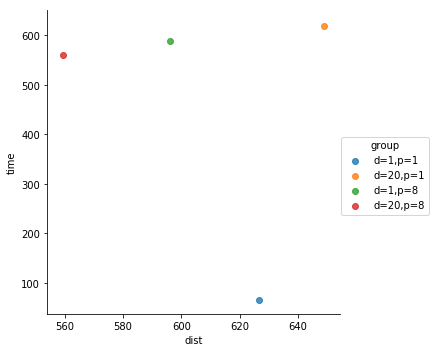

In [74]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
 
# Create dataframe
df = pd.DataFrame({
'dist': storage_opt_dist[:,0].tolist(),
'time': storage_opt_dist[:,1].tolist(),
'group': ['d=1,p=1','d=20,p=1','d=1,p=8','d=20,p=8']
})
 
sns.lmplot(data=df, x="dist", y="time", fit_reg=False, hue='group')
#sns.plt.show()


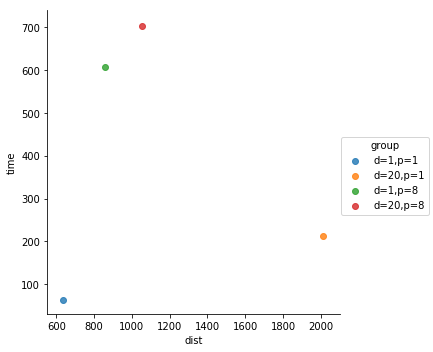

In [75]:
# Create dataframe
df = pd.DataFrame({
'dist': storage_opt_time[:,0].tolist(),
'time': storage_opt_time[:,1].tolist(),
'group': ['d=1,p=1','d=20,p=1','d=1,p=8','d=20,p=8']
})
 
sns.lmplot(data=df, x="dist", y="time", fit_reg=False, hue='group')
#sns.plt.show()


The first graph above shows the distance and time plot for the minimas found given the group parameters using distance as the cost function. The second graph shows us the same situation except we use the time as the cost function. 

The key takeaway is that depending on which flights you travel on and what sets those conditions, you have a range of different optima in the time and distance domain. Simulated Annealing can help us tune these parameters and see how the optimas change!